# Project Part 3

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/ciscoyslas/deeplearningmodelyslas/edit)


_This notebook will build a deep learning model to predict ABV (Alcohol by Volume) from a dataset of craft beers._

## 1. Introduction/Background

_Adding imports to help with the project, KeyedVectors and Word2Vec are pre-trained word embeddings for my project._

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Exploratory Data Analysis

_Dropping null values within the 'ibu'(International Bitterness Unit) column of my dataset as not every beer has an IBU value attributed to it by brewers.  Null values will mess with my regression and not give me accurate training data._

In [2]:
beers_df = pd.read_csv('/kaggle/input/craft-cans/beers.csv')
test_df = pd.read_csv('/kaggle/input/craft-cans/beers.csv')
beers_df = beers_df.dropna(subset=['ibu'])
test_df = test_df.dropna(subset=['ibu'])
#print(beers_df.isnull().sum()) #Checking if null values got dropped from the ibu column

## 3. Building the Model

_Next, we are loading our pre-trained embeddings and tokenizing/normalizing our features. 2 tokenizations for the text features and one normalization for our numerical features._

In [3]:
# Loading pre-trained Word2Vec embeddings
word2vec_path = '/kaggle/input/word-embeddings/GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Tokenize and pad sequences for the 'style' column
max_sequence_length_style = 50
text_data_style = pad_sequences(beers_df['style'].apply(lambda x: [word2vec_model.key_to_index[word] for word in str(x).split() if word in word2vec_model.key_to_index]).tolist(), maxlen=max_sequence_length_style)

# Tokenize and pad sequences for the 'name' column
max_sequence_length_name = 20 
text_data_name = pad_sequences(beers_df['name'].apply(lambda x: [word2vec_model.key_to_index[word] for word in str(x).split() if word in word2vec_model.key_to_index]).tolist(), maxlen=max_sequence_length_name)

# Normalize numerical features
numerical_data = MinMaxScaler().fit_transform(beers_df[['ibu', 'ounces']].values)

_The next two cells define and run the model.  The inputs (text and numerical) are combined to make the two different data types work nicely together._

In [4]:
# Concatenate text and numerical features
X_text = np.concatenate([text_data_style, text_data_name], axis=1)
X_num = numerical_data
y = beers_df['abv'].values

#Define input layers
input_text = Input(shape=(max_sequence_length_style + max_sequence_length_name,))
input_num = Input(shape=(2,)) 

# Word embedding layer for text data
embedding_layer = Embedding(input_dim=len(word2vec_model.key_to_index), output_dim=200, input_length=max_sequence_length_style + max_sequence_length_name)(input_text)
flatten_layer = Flatten()(embedding_layer)

# Concatenate the flattened text data and numerical data
concatenated_layer = Concatenate()([flatten_layer, input_num])

# Dense layers for the combined data
dense1 = Dense(128, activation='relu')(concatenated_layer)
output_layer = Dense(1)(dense1)

In [5]:
# Split the data into training and validation sets
X_train_text, X_val_text, X_train_num, X_val_num, y_train, y_val = train_test_split(X_text, X_num, y, test_size=0.2, random_state=42)

# Define the model
model = Model(inputs=[input_text, input_num], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model and saving training data for a visual representation
training_results = model.fit([X_train_text, X_train_num], y_train, epochs=10, batch_size = 20, validation_data=([X_val_text, X_val_num], y_val))

Epoch 1/10
57/57 [==============================] - 12s 135ms/step - loss: 0.0478 - val_loss: 1.0649e-04
Epoch 2/10
57/57 [==============================] - 4s 72ms/step - loss: 1.0849e-04 - val_loss: 8.7757e-05
Epoch 3/10
57/57 [==============================] - 5s 87ms/step - loss: 5.0213e-05 - val_loss: 7.9531e-05
Epoch 4/10
57/57 [==============================] - 4s 66ms/step - loss: 4.2733e-05 - val_loss: 8.0984e-05
Epoch 5/10
57/57 [==============================] - 4s 63ms/step - loss: 3.4479e-05 - val_loss: 1.0374e-04
Epoch 6/10
57/57 [==============================] - 4s 63ms/step - loss: 3.8699e-05 - val_loss: 7.6003e-05
Epoch 7/10
57/57 [==============================] - 3s 59ms/step - loss: 4.7793e-05 - val_loss: 1.7585e-04
Epoch 8/10
57/57 [==============================] - 3s 59ms/step - loss: 5.6277e-05 - val_loss: 8.0022e-05
Epoch 9/10
57/57 [==============================] - 4s 66ms/step - loss: 3.9932e-05 - val_loss: 7.0454e-05
Epoch 10/10
57/57 [====================

_Evaluation of the model._

In [6]:
# Evaluate the model on a test set
X_test_text_style = pad_sequences(test_df['style'].apply(lambda x: [word2vec_model.key_to_index[word] for word in str(x).split() if word in word2vec_model.key_to_index]).tolist(), maxlen=max_sequence_length_style)
X_test_text_name = pad_sequences(test_df['name'].apply(lambda x: [word2vec_model.key_to_index[word] for word in str(x).split() if word in word2vec_model.key_to_index]).tolist(), maxlen=max_sequence_length_name)
X_test_num = MinMaxScaler().fit_transform(test_df[['ibu', 'ounces']].values)
model.evaluate([np.concatenate([X_test_text_style, X_test_text_name], axis=1), X_test_num], test_df['abv'].values)


44/44 [==============================] - 0s 2ms/step - loss: 7.0464e-05


7.046389509923756e-05

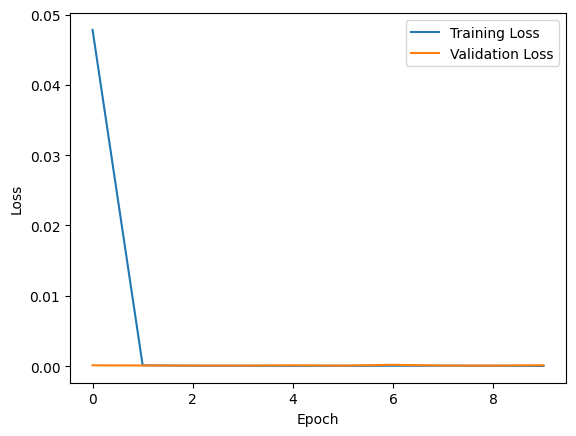

In [7]:
plt.plot(training_results.history['loss'], label='Training Loss')
plt.plot(training_results.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()